# Diffusion and Dispersion in Solute Transport

## Physical Background: Dispersion as Scale-Dependent Heterogeneity

All spreading in groundwater transport arises from **velocity heterogeneity**. What we call "dispersion" vs "heterogeneity" is simply a matter of observation scale:

| Scale | Mechanism | gwtransport representation |
|-------|-----------|---------------------------|
| Molecular | Brownian motion | $D_m$ (molecular diffusivity) |
| Pore (~mm-cm) | Velocity variations in pores | $\alpha_L$ (dispersivity) |
| Aquifer (~m-km) | Different streamline paths | APVD ($\sigma_{apv}$) |

**Key insight**: These are the same phenomenon at different resolutions. The boundaries are not sharp—this is why measured $\alpha_L$ increases with experiment scale.

### When to use each approach

| APVD source | Recommendation |
|-------------|----------------|
| **Breakthrough curve fitting** | Use APVD only (dispersion already absorbed in $\sigma_{apv}$) |
| **Streamline analysis** | Can add $\alpha_L$ for unresolved pore-scale effects |
| **Either** | Use "equivalent APVD std" to combine and use fast advection module |

## Spreading Components

Breakthrough curve spreading arises from three independent processes:

| Component                 | Symbol          | Physical cause                 | Pore velocity scaling                     |
| ------------------------- | --------------- | ------------------------------ | ----------------------------------------- |
| **Aquifer heterogeneity** | $\sigma_{apv}$  | Different streamline lengths   | $\propto \tau$                            |
| **Molecular diffusion**   | $\sigma_{diff}$ | Brownian motion                | $\propto \sqrt{\tau}$, independent of $v$ |
| **Mechanical dispersion** | $\sigma_{disp}$ | Pore-scale velocity variations | $\propto \sqrt{\tau}$, scales with $v$    |

where $v$ is the pore velocity (= specific discharge $q$ / porosity $n$).

**Key insight**: Molecular diffusion and mechanical dispersion produce spreading characterized by $\sigma_x = \sqrt{2 D_L \tau}$. This spatial spreading can be converted to equivalent APVD units for comparison with aquifer heterogeneity.

## Modeling Approaches

| Method                   | Function                                     | Speed | Use when                      |
| ------------------------ | -------------------------------------------- | ----- | ----------------------------- |
| **APVD only**            | `advection.gamma_infiltration_to_extraction` | Fast  | Dispersion negligible         |
| **APVD + increased std** | Same, with adjusted `std`                    | Fast  | Approximate dispersion. Flow relatively constant. |
| **Full solution**        | `diffusion.infiltration_to_extraction`      | Slow  | Variable flow, high precision |


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gwtransport import advection, diffusion

np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")

## 1. System Parameters

The input parameters are organized in three groups:
- **Aquifer geometry**: streamline length $L$ and aquifer pore volume distribution (mean $\bar{V}$, std $\sigma_{apv}$)
- **Flow**: mean discharge $Q$
- **Transport**: retardation factor $R$, molecular diffusivity $D_m$, and longitudinal dispersivity $\alpha_L$

In [2]:
# Aquifer geometry
streamline_length = 100.0  # L [m]
mean_apv = 10000.0  # V_mean [m³] Mean aquifer pore volume
std_apv = 800.0  # sigma_apv [m³] Std from aquifer heterogeneity

# Flow
mean_flow = 120.0  # Q [m³/day]

# Transport
retardation = 2.0  # R [-] Retardation factor
diffusivity_molecular = 1e-4  # D_m [m²/day] Molecular diffusion (~1e-9 m²/s)
dispersivity = 1.0  # alpha_L [m] Longitudinal dispersivity

## 2. Equivalent APVD Spreading from Diffusion/Dispersion

The spatial spreading $\sigma_x = \sqrt{2 D_L \tau_{solute}}$ can be converted to equivalent APVD spreading.

After substitution (see derivation below), the formulas simplify to expressions using only input parameters:

$$\sigma_{diff} = \frac{\bar{V}}{L} \sqrt{\frac{2 D_m R \bar{V}}{Q}}$$

$$\sigma_{disp} = \bar{V} \sqrt{\frac{2 \alpha_L}{L}}$$

$$\sigma_{diff,disp} = \bar{V} \sqrt{\frac{2 D_m R}{L Q} + \frac{2 \alpha_L}{L}}$$

<details>
<summary>Derivation</summary>

Starting from $\sigma_x = \sqrt{2 D \tau_{solute}}$ and converting to APVD units via $\sigma = \sigma_x \cdot \bar{V} / L$:

**Molecular diffusion** ($D = D_m$, constant):
$$\sigma_{x,diff} = \sqrt{2 D_m \tau_{solute}} = \sqrt{2 D_m R \bar{V} / Q}$$
$$\sigma_{diff} = \frac{\bar{V}}{L} \sqrt{\frac{2 D_m R \bar{V}}{Q}}$$

**Mechanical dispersion** ($D = \alpha_L v = \alpha_L L / \tau_{solute}$):
$$\sigma_{x,disp}^2 = 2 D_{disp} \tau_{solute} = 2 \alpha_L \frac{L}{\tau_{solute}} \tau_{solute} = 2 \alpha_L L$$
$$\sigma_{x,disp} = \sqrt{2 \alpha_L L}$$
$$\sigma_{disp} = \frac{\bar{V}}{L} \sqrt{2 \alpha_L L} = \bar{V} \sqrt{\frac{2 \alpha_L}{L}}$$

Note: The retardation factor $R$ cancels out for mechanical dispersion because both $D_{disp} \propto 1/\tau$ and $\tau \propto R$.

**Combined** (variances add since processes are independent):
$$\sigma_{diff,disp}^2 = \sigma_{diff}^2 + \sigma_{disp}^2 = \frac{\bar{V}^2}{L^2} \cdot \frac{2 D_m R \bar{V}}{Q} + \bar{V}^2 \cdot \frac{2 \alpha_L}{L}$$

</details>

In [3]:
# Equivalent APVD spreading from molecular diffusion
sigma_diff = (mean_apv / streamline_length) * np.sqrt(2 * diffusivity_molecular * retardation * mean_apv / mean_flow)

# Equivalent APVD spreading from mechanical dispersion
# Note: R cancels out because D_disp = alpha_L * v = alpha_L * L / tau, and D_disp * tau = alpha_L * L
sigma_disp = mean_apv * np.sqrt(2 * dispersivity / streamline_length)

# Combined spreading (direct formula)
sigma_diff_disp = mean_apv * np.sqrt(
    2 * diffusivity_molecular * retardation / (streamline_length * mean_flow) + 2 * dispersivity / streamline_length
)

print("Equivalent APVD spreading contributions:")
print(f"  sigma_diff (molecular diffusion):   {sigma_diff:6.0f} m³")
print(f"  sigma_disp (mechanical dispersion): {sigma_disp:6.0f} m³")
print(f"  sigma_diff_disp (combined):         {sigma_diff_disp:6.0f} m³")

Equivalent APVD spreading contributions:
  sigma_diff (molecular diffusion):       18 m³
  sigma_disp (mechanical dispersion):   1414 m³
  sigma_diff_disp (combined):           1414 m³


## 3. Equivalent APVD Standard Deviation

Combine original APVD heterogeneity with diffusion/dispersion spreading:

$$\sigma_{apv,diff,disp} = \sqrt{\sigma_{apv}^2 + \sigma_{diff,disp}^2}$$

In [4]:
# Combined APVD std
sigma_apv_diff_disp = np.sqrt(std_apv**2 + sigma_diff_disp**2)

# Variance fractions
frac_apv = std_apv**2 / sigma_apv_diff_disp**2 * 100
frac_diff_disp = sigma_diff_disp**2 / sigma_apv_diff_disp**2 * 100

print(f"sigma_apv:          {std_apv:7.0f} m³  ({frac_apv:.0f}% of variance)")
print(f"sigma_diff_disp:    {sigma_diff_disp:7.0f} m³  ({frac_diff_disp:.0f}% of variance)")
print(f"sigma_apv_diff_disp:{sigma_apv_diff_disp:7.0f} m³")

print("\n" + "=" * 50)
if frac_diff_disp < 5:
    print("RECOMMENDATION: Ignore diffusion/dispersion")
elif frac_diff_disp < 25:
    print("RECOMMENDATION: Use APVD with increased std")
else:
    print("RECOMMENDATION: Use diffusion for accuracy")
print("=" * 50)

sigma_apv:              800 m³  (24% of variance)
sigma_diff_disp:       1414 m³  (76% of variance)
sigma_apv_diff_disp:   1625 m³

RECOMMENDATION: Use diffusion for accuracy


## Using Combined Std with Advection Module (Fast Approach)

When diffusion/dispersion effects are significant but you want the speed of the advection module, use the combined standard deviation. This is valid because both APVD heterogeneity and pore-scale dispersion represent the same physical phenomenon (velocity heterogeneity) at different observation scales—their variances can be added.

```python
# Instead of calling diffusion.infiltration_to_extraction (slow),
# use advection with combined std (fast):
cout_fast = advection.gamma_infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    mean=mean_apv,
    std=sigma_apv_diff_disp,  # Combined: sqrt(σ²_apv + σ²_diff_disp)
    n_bins=nbins,
    retardation_factor=retardation,
)
```

**When is this approach valid?**
- Flow is relatively constant (so diffusion effects are well-approximated)
- You want fast computation with reasonable accuracy
- Either APVD was calibrated from streamlines OR you want to add diffusion to existing APVD

**When to use full diffusion module instead:**
- Flow varies significantly over time
- High precision is required
- You need to model different dispersivities for different pore volumes

## 4. Numerical Validation


In [5]:
n_days = 350
_tedges = pd.date_range("2019-12-31", periods=n_days + 1, freq="D")

_flow = np.full(n_days, mean_flow)
_cin = np.zeros(n_days)
_cin[50] = 100.0

cin_itedges = np.flatnonzero(np.diff(_cin, prepend=1.0, append=1.0))
flow_itedges = np.flatnonzero(np.diff(_flow, prepend=1.0, append=1.0))
itedges = np.unique(np.concatenate([cin_itedges, flow_itedges]))
tedges = _tedges[itedges]

cin = _cin[itedges[:-1]]
flow = _flow[itedges[:-1]]

cout_tedges = _tedges.copy()

nbins = 5000
streamline_lengths = np.full(nbins, streamline_length)

In [6]:
# 1. APVD only (no diffusion/dispersion)
cout_apvd = advection.gamma_infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    mean=mean_apv,
    std=std_apv,
    n_bins=nbins,
    retardation_factor=retardation,
)

# 2. Full solution: diffusion with a single pore volume
# Uses mean_apv as the single representative pore volume
# The diffusion module computes D_L = D_m + alpha_L * v internally
cout_diffusion = diffusion.infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    aquifer_pore_volumes=np.array([mean_apv]),
    streamline_length=np.array([streamline_length]),
    molecular_diffusivity=diffusivity_molecular,
    longitudinal_dispersivity=dispersivity,
    retardation_factor=retardation,
)

# 3. APVD with combined std (approximation)
# This should match cout_diffusion when using a single pore volume
cout_apvd_combined = advection.gamma_infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    mean=mean_apv,
    std=sigma_diff_disp,  # Only diffusion/dispersion spreading, no APVD heterogeneity
    n_bins=nbins,
    retardation_factor=retardation,
)

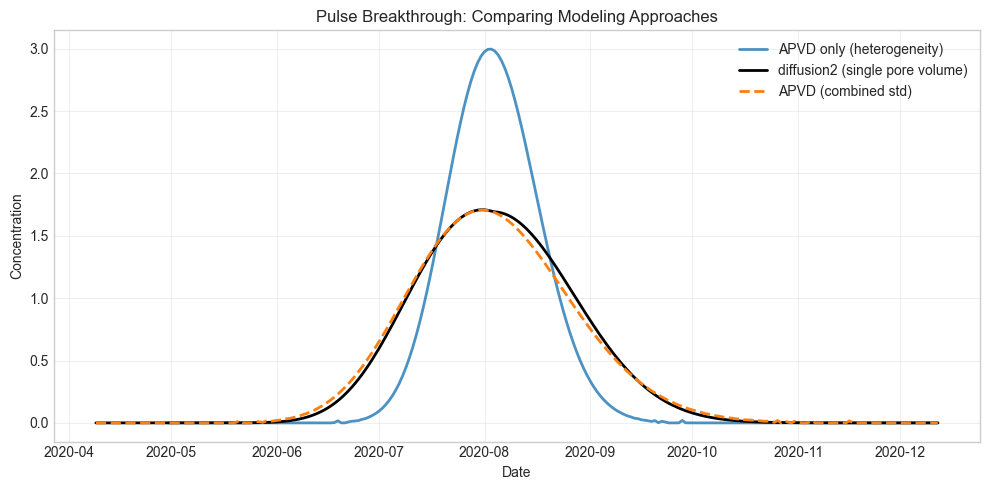

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot around breakthrough
plot_start, plot_end = 100, 349
t_plot = cout_tedges[plot_start:plot_end]

ax.plot(t_plot[:-1], cout_apvd[plot_start : plot_end - 1], label="APVD only (heterogeneity)", linewidth=2, alpha=0.8)
ax.plot(
    t_plot[:-1],
    cout_diffusion[plot_start : plot_end - 1],
    label="diffusion (single pore volume)",
    linewidth=2,
    linestyle="-",
    color="black",
)
ax.plot(
    t_plot[:-1], cout_apvd_combined[plot_start : plot_end - 1], label="APVD (combined std)", linewidth=2, linestyle="--"
)

ax.set_xlabel("Date")
ax.set_ylabel("Concentration")
ax.set_title("Pulse Breakthrough: Comparing Modeling Approaches")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

**Formulas for equivalent APVD spreading (directly from input parameters):**

$$\sigma_{diff} = \frac{\bar{V}}{L} \sqrt{\frac{2 D_m R \bar{V}}{Q}} \quad \text{(molecular diffusion)}$$

$$\sigma_{disp} = \bar{V} \sqrt{\frac{2 \alpha_L}{L}} \quad \text{(mechanical dispersion, R cancels)}$$

$$\sigma_{diff,disp} = \bar{V} \sqrt{\frac{2 D_m R}{L Q} + \frac{2 \alpha_L}{L}} \quad \text{(combined)}$$

**When to include diffusion/dispersion:**

- $\sigma_{diff,disp}^2 / \sigma_{apv}^2 < 0.05$: Ignore diffusion/dispersion
- Ratio 0.05–0.25: Use APVD with combined std
- Ratio > 0.25: Use `diffusion.infiltration_to_extraction` for accuracy